## Importing Packages and Loading Images

In [15]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
from math import log10, sqrt
from scipy.ndimage import sobel
import pywt
from prettytable import PrettyTable



PATH_TO_IMAGE = 'TestingImages/test1.jpg'
# Load an image file
image = Image.open(PATH_TO_IMAGE)  # Replace with your image file path

# Convert the image to a NumPy array
image_array = np.array(image)

print('Before converting to black and white')
print(f'Shape: {image_array.shape}, Dimension: {image_array.ndim}')


print('\nAfter converting to black and white')
image_gray = image.convert('L')
image_gray_array = np.array(image_gray)
print(f'Shape: {image_gray_array.shape}, Dimension: {image_gray_array.ndim}')



Before converting to black and white
Shape: (5568, 3712, 3), Dimension: 3

After converting to black and white
Shape: (5568, 3712), Dimension: 2


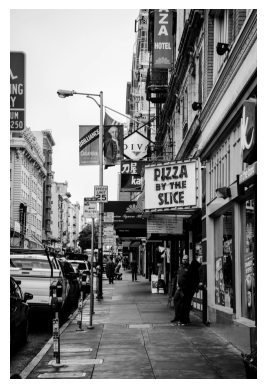

In [3]:
plt.imshow(image_gray_array, cmap='gray')  # Use grayscale color map
plt.axis('off')  # Hide axes
plt.show()

## Addding Noise

In [4]:
def add_gaussian_noise(image, mean=0, var=0.1):
    image = image.copy()
    sigma = var ** 0.5
    gaussian = np.random.normal(mean, sigma, image.shape)
    gaussian = gaussian.reshape(image.shape)
    noisy_image = image + gaussian
    # noisy_image = np.clip(noisy_image, 0, 1)  # Assuming image pixel values range from 0 to 1
    return noisy_image
def add_salt_pepper_noise(image, amount=0.01, salt_vs_pepper=0.5):
    image = image.copy()
    num_salt = np.ceil(amount * image.size * salt_vs_pepper)
    num_pepper = np.ceil(amount * image.size * (1.0 - salt_vs_pepper))

    # Add Salt noise
    coords = [np.random.randint(0, i - 1, int(num_salt)) for i in image.shape]
    image[coords[0], coords[1]] = 1

    # Add Pepper noise
    coords = [np.random.randint(0, i - 1, int(num_pepper)) for i in image.shape]
    image[coords[0], coords[1]] = 0

    return image
def add_poisson_noise(image):
    image = image.copy()
    vals = len(np.unique(image))
    vals = 2 ** np.ceil(np.log2(vals))
    noisy_image = np.random.poisson(image * vals) / float(vals)
    return noisy_image
def add_speckle_noise(image):
    image = image.copy()
    row, col = image.shape
    gauss = np.random.randn(row, col)
    gauss = gauss.reshape(row,col)
    noisy_image = image + image * gauss
    # noisy_image = np.clip(noisy_image, 0, 1)  # Assuming image pixel values range from 0 to 1
    return noisy_image


In [5]:
gaussian_image_array = add_gaussian_noise(image_gray_array.copy(), mean=0, var = 100)

In [6]:
salt_pepper_image_array = add_salt_pepper_noise(image_gray_array.copy(),amount=0.3, salt_vs_pepper=0.5)

In [7]:
poisson_image_array = add_poisson_noise(image_gray_array.copy())

In [8]:
speckle_image_array = add_speckle_noise(image_gray_array)

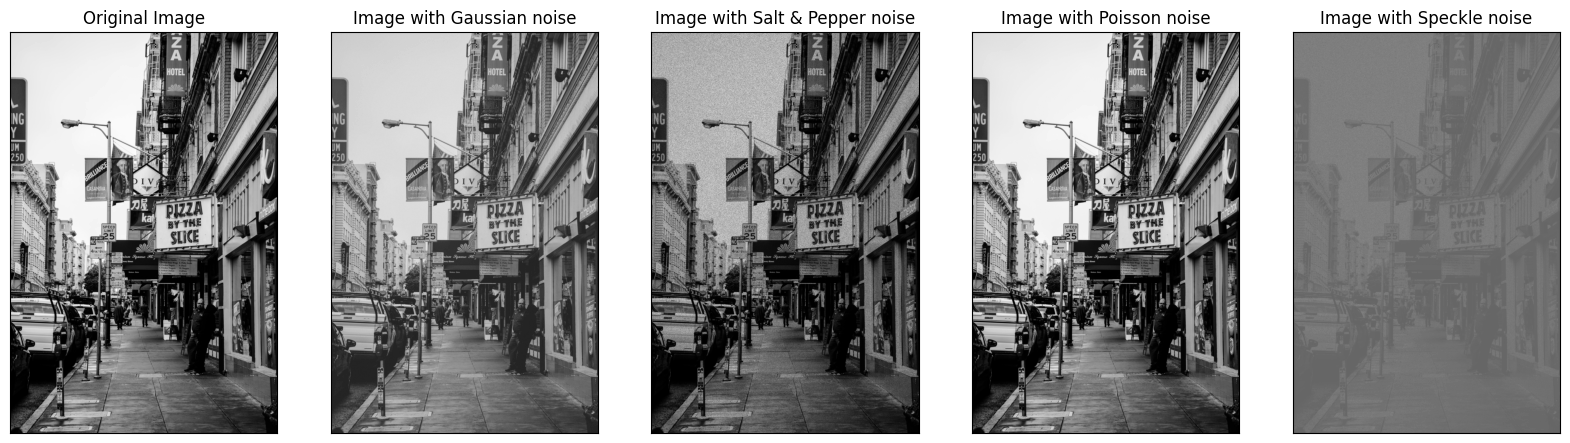

In [ ]:
fig, axs = plt.subplots(1, 5, figsize=(20, 6))  # Adjust figsize as needed

# Display the first image on the left subplot
axs[0].imshow(image_gray_array, cmap='gray')
axs[0].set_title('Original Image')
axs[0].set_xticks([])
axs[0].set_yticks([])

axs[1].imshow(gaussian_image_array, cmap='gray')
axs[1].set_title('Image with Gaussian noise')
axs[1].set_xticks([])
axs[1].set_yticks([])

axs[2].imshow(salt_pepper_image_array, cmap='gray')
axs[2].set_title('Image with Salt & Pepper noise')
axs[2].set_xticks([])
axs[2].set_yticks([])

axs[3].imshow(poisson_image_array, cmap='gray')
axs[3].set_title('Image with Poisson noise')
axs[3].set_xticks([])
axs[3].set_yticks([])

axs[4].imshow(speckle_image_array, cmap='gray')
axs[4].set_title('Image with Speckle noise')
axs[4].set_xticks([])
axs[4].set_yticks([])

# Show the plot
plt.show()

## Anisotropic Diffusion

In [ ]:
def anisotropic_diffusion(img, n_iter=10, kappa=50, gamma=0.1, option=1):
    """
    Apply anisotropic diffusion (Perona-Malik filter) to an image.

    Parameters:
        img (numpy.ndarray): The input image (2D grayscale image).
        n_iter (int): Number of iterations.
        kappa (float): Conduction coefficient, controls sensitivity to edges.
        gamma (float): Time step, a larger value increases the speed of diffusion.
        option (int): 1 or 2, selects the type of diffusion equation.

    Returns:
        numpy.ndarray: Diffused image.
    """

    # Convert image to float type for precision
    img = img.astype('float32')

    for i in range(n_iter):
        # Calculate gradients
        delta_north = np.roll(img, -1, axis=0) - img
        delta_south = np.roll(img, 1, axis=0) - img
        delta_east = np.roll(img, 1, axis=1) - img
        delta_west = np.roll(img, -1, axis=1) - img

        # Calculate diffusion based on the selected option
        if option == 1:
            c_north = np.exp(-(delta_north/kappa)**2)
            c_south = np.exp(-(delta_south/kappa)**2)
            c_east = np.exp(-(delta_east/kappa)**2)
            c_west = np.exp(-(delta_west/kappa)**2)
        elif option == 2:
            c_north = 1 / (1 + (delta_north/kappa)**2)
            c_south = 1 / (1 + (delta_south/kappa)**2)
            c_east = 1 / (1 + (delta_east/kappa)**2)
            c_west = 1 / (1 + (delta_west/kappa)**2)

        # Update image
        img += gamma * (
            c_north * delta_north +
            c_south * delta_south +
            c_east * delta_east +
            c_west * delta_west
        )

    return img



## Error Metrics

In [12]:
def mse(imageA, imageB):
    # the 'Mean Squared Error' between the two images is the
    # sum of the squared difference between the two images;
    # NOTE: the two images must have the same dimension
    err = np.sum((imageA.astype("float") - imageB.astype("float")) ** 2)
    err /= float(imageA.shape[0] * imageA.shape[1])
    return err

def psnr(imageA, imageB):
    # calculate mean squared error
    mse_value = mse(imageA, imageB)
    # calculate PSNR (Peak Signal to Noise Ratio)
    if mse_value == 0:
        return 100
    MAX_PIXEL = 255.0
    return 20 * log10(MAX_PIXEL / sqrt(mse_value))

def ssim_index(imageA, imageB):
    # calculate SSIM (Structural Similarity Index)
    return ssim(imageA, imageB, data_range=imageB.max() - imageB.min())

def snr(original, denoised):
    signal = np.mean(denoised)
    noise = np.std(denoised - original)
    return 10 * np.log10(signal**2 / noise**2)



def epi(original, denoised):
    # Calculate the gradient magnitude using Sobel operator for the original image
    sobel_original_x = sobel(original, axis=0, mode='constant')
    sobel_original_y = sobel(original, axis=1, mode='constant')
    gradient_original = np.hypot(sobel_original_x, sobel_original_y)

    # Calculate the gradient magnitude for the denoised image
    sobel_denoised_x = sobel(denoised, axis=0, mode='constant')
    sobel_denoised_y = sobel(denoised, axis=1, mode='constant')
    gradient_denoised = np.hypot(sobel_denoised_x, sobel_denoised_y)

    # Use mean squared error on the gradient magnitudes as a simple EPI
    return -mse(gradient_original, gradient_denoised)  # Negative to maintain the 'error' interpretation


## Experiment

In [ ]:
import numpy as np
from itertools import product

def opt(original_image_array, noisy_image_array):
    # Define a grid of parameter values to search
    n_iter_values = [20, 50, 100]  # Example values for number of iterations
    kappa_values = [10, 20]   # Example values for kappa
    gamma_values = [0.05, 0.1, 0.2] # Example values for gamma
    option_values = [1, 2]        # Example values for option

    # Initialize variables to store best parameters and MSE
    best_params = None
    best_mse = float('inf')
    best_image_array = None

    # Loop through all combinations of parameters
    for n_iter, kappa, gamma, option in product(n_iter_values, kappa_values, gamma_values, option_values):
        # Apply anisotropic diffusion with current parameters
        diffused_image = anisotropic_diffusion(noisy_image_array.copy(), n_iter=n_iter, kappa=kappa, gamma=gamma, option=option)

        # Compute MSE between diffused image and target image (imageB)
        current_mse = mse(diffused_image, original_image_array)

        # Update best parameters if current MSE is lower
        if current_mse < best_mse:
            best_mse = current_mse
            best_params = (n_iter, kappa, gamma, option)
            best_image_array = diffused_image

    # Print best parameters and corresponding MSE
    print("Best parameters:", best_params)
    print("Best MSE:", best_mse)
    return best_image_array

In [ ]:
gaussian_denoised = opt(image_gray_array.copy(), gaussian_image_array.copy())
salt_pepper_denoised = opt(image_gray_array.copy(), salt_pepper_image_array.copy())
poisson_denoised = opt(image_gray_array.copy(), poisson_image_array.copy())
speckle_denoised = opt(image_gray_array.copy(), speckle_image_array.copy())

Best parameters: (20, 20, 0.05, 2)
Best MSE: 22.07942157447247
Best parameters: (100, 20, 0.2, 2)
Best MSE: 1909.433660163865
Best parameters: (20, 10, 0.05, 1)
Best MSE: 5.820018973643632
Best parameters: (100, 20, 0.2, 2)
Best MSE: 9653.34029181819


## Performance Evaluatoin

### Gaussian

[]

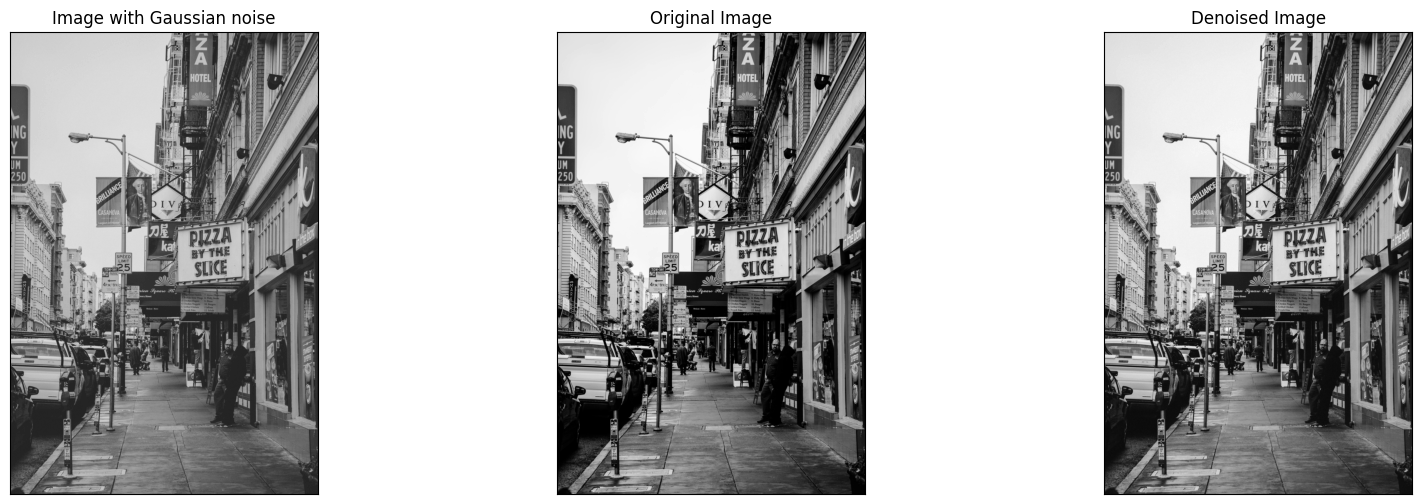

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(20, 6))  # Adjust figsize as needed

axs[0].imshow(gaussian_image_array, cmap='gray')
axs[0].set_title('Image with Gaussian noise')
axs[0].set_xticks([])
axs[0].set_yticks([])

axs[1].imshow(image_gray_array, cmap='gray')
axs[1].set_title('Original Image')
axs[1].set_xticks([])
axs[1].set_yticks([])

axs[2].imshow(gaussian_denoised, cmap='gray')
axs[2].set_title('Denoised Image')
axs[2].set_xticks([])
axs[2].set_yticks([])

### Salt & Pepper

[]

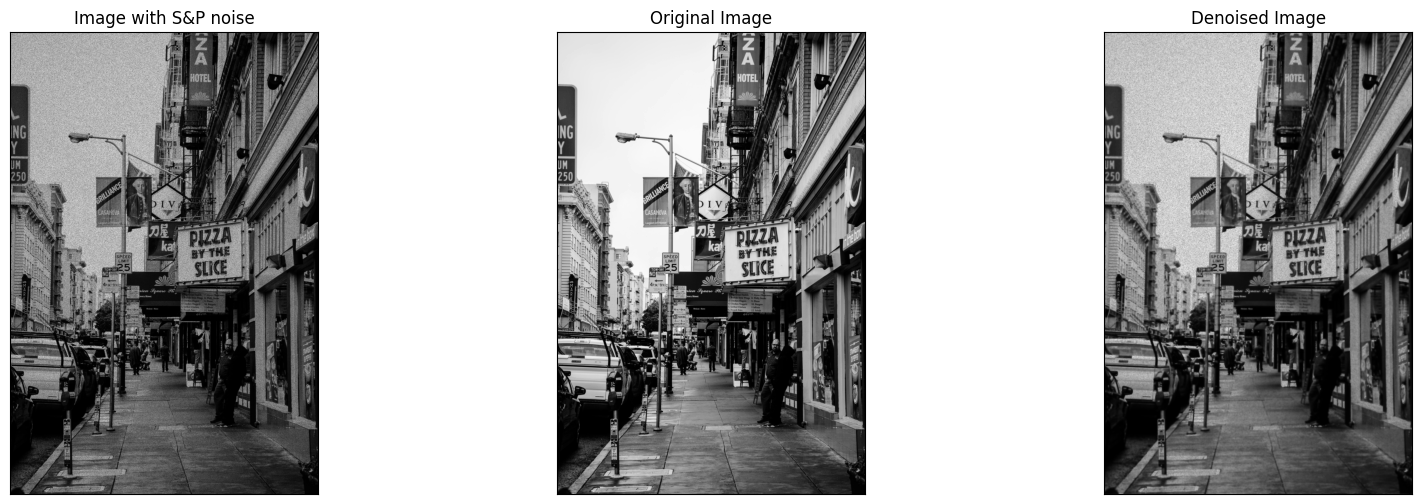

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(20, 6))  # Adjust figsize as needed

axs[0].imshow(salt_pepper_image_array, cmap='gray')
axs[0].set_title('Image with S&P noise')
axs[0].set_xticks([])
axs[0].set_yticks([])

axs[1].imshow(image_gray_array, cmap='gray')
axs[1].set_title('Original Image')
axs[1].set_xticks([])
axs[1].set_yticks([])

axs[2].imshow(salt_pepper_denoised, cmap='gray')
axs[2].set_title('Denoised Image')
axs[2].set_xticks([])
axs[2].set_yticks([])

### Poisson

[]

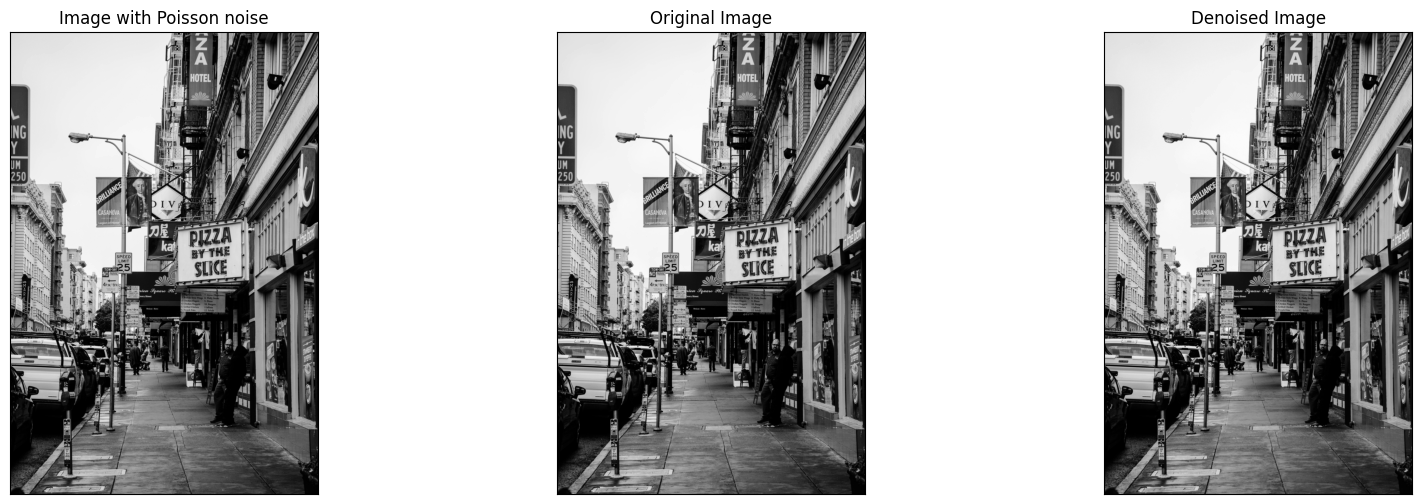

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(20, 6))  # Adjust figsize as needed

axs[0].imshow(poisson_image_array, cmap='gray')
axs[0].set_title('Image with Poisson noise')
axs[0].set_xticks([])
axs[0].set_yticks([])

axs[1].imshow(image_gray_array, cmap='gray')
axs[1].set_title('Original Image')
axs[1].set_xticks([])
axs[1].set_yticks([])

axs[2].imshow(poisson_denoised, cmap='gray')
axs[2].set_title('Denoised Image')
axs[2].set_xticks([])
axs[2].set_yticks([])

### Speckle

[]

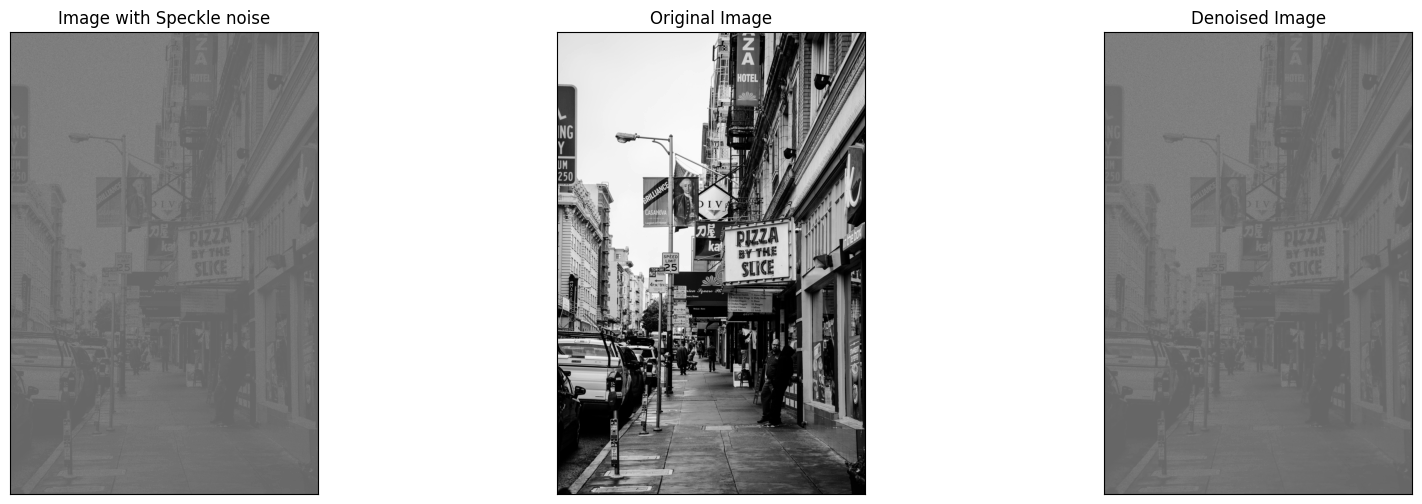

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(20, 6))  # Adjust figsize as needed

axs[0].imshow(speckle_image_array, cmap='gray')
axs[0].set_title('Image with Speckle noise')
axs[0].set_xticks([])
axs[0].set_yticks([])

axs[1].imshow(image_gray_array, cmap='gray')
axs[1].set_title('Original Image')
axs[1].set_xticks([])
axs[1].set_yticks([])

axs[2].imshow(speckle_denoised, cmap='gray')
axs[2].set_title('Denoised Image')
axs[2].set_xticks([])
axs[2].set_yticks([])

### Errors


In [ ]:
print('For Gaussian Noise')
print(f'MSE: {mse(image_gray_array.copy(), gaussian_denoised.copy())}')
print(f'PSNR: {psnr(image_gray_array.copy(), gaussian_denoised.copy())}')
print(f'SSIM_INDEX: {ssim_index(image_gray_array.copy(), gaussian_denoised.copy())}')
print(f'SNR: {snr(image_gray_array.copy(), gaussian_denoised.copy())}')
print(f'EPI: {epi(image_gray_array.copy(), gaussian_denoised.copy())}')

print()
print('For Salt & Pepper Noise')
print(f'MSE: {mse(image_gray_array.copy(), salt_pepper_denoised.copy())}')
print(f'PSNR: {psnr(image_gray_array.copy(), salt_pepper_denoised.copy())}')
print(f'SSIM_INDEX: {ssim_index(image_gray_array.copy(), salt_pepper_denoised.copy())}')
print(f'SNR: {snr(image_gray_array.copy(), salt_pepper_denoised.copy())}')
print(f'EPI: {epi(image_gray_array.copy(), salt_pepper_denoised.copy())}')

print()
print('For Poisson Noise')
print(f'MSE: {mse(image_gray_array.copy(), poisson_denoised.copy())}')
print(f'PSNR: {psnr(image_gray_array.copy(), poisson_denoised.copy())}')
print(f'SSIM_INDEX: {ssim_index(image_gray_array.copy(), poisson_denoised.copy())}')
print(f'SNR: {snr(image_gray_array.copy(), poisson_denoised.copy())}')
print(f'EPI: {epi(image_gray_array.copy(), poisson_denoised.copy())}')

print()
print('For Speckle Noise')
print(f'MSE: {mse(image_gray_array.copy(), speckle_denoised.copy())}')
print(f'PSNR: {psnr(image_gray_array.copy(), speckle_denoised.copy())}')
print(f'SSIM_INDEX: {ssim_index(image_gray_array.copy(), speckle_denoised.copy())}')
print(f'SNR: {snr(image_gray_array.copy(), speckle_denoised.copy())}')
print(f'EPI: {epi(image_gray_array.copy(), speckle_denoised.copy())}')

For Gaussian Noise
MSE: 22.07942157447247
PSNR: 34.69092669089067
SSIM_INDEX: 0.9200095965690045
SNR: 28.11641000842709
EPI: -33104.608311453216

For Salt & Pepper Noise
MSE: 1909.433660163865
PSNR: 15.321757866766422
SSIM_INDEX: 0.4879098420367284
SNR: 9.157907005247402
EPI: -39035.3417469472

For Poisson Noise
MSE: 5.820018973643632
PSNR: 40.48155960387214
SSIM_INDEX: 0.9697172996357983
SNR: 33.906778281812684
EPI: -34178.44591395587

For Speckle Noise
MSE: 9653.34029181819
PSNR: 8.284027450068193
SSIM_INDEX: 0.6476503772672839
SNR: 1.7067387833356853
EPI: -234089.95718381912


In [16]:
# Error metrics data for different noise types
error_metrics = {
    "Gaussian Noise": {"MSE": 22.07942157447247, "PSNR": 34.69092669089067, "SSIM_INDEX": 0.9200095965690045, "SNR": 28.11641000842709, "EPI": -33104.608311453216},
    "Salt & Pepper Noise": {"MSE": 1909.433660163865, "PSNR": 15.321757866766422, "SSIM_INDEX": 0.4879098420367284, "SNR": 9.157907005247402, "EPI": -39035.3417469472},
    "Poisson Noise": {"MSE": 5.820018973643632, "PSNR": 40.48155960387214, "SSIM_INDEX": 0.9697172996357983, "SNR": 33.906778281812684, "EPI": -34178.44591395587},
    "Speckle Noise": {"MSE": 9653.34029181819, "PSNR": 8.284027450068193, "SSIM_INDEX": 0.6476503772672839, "SNR": 1.7067387833356853, "EPI": -234089.95718381912}
}

# Define function to generate table for a specific metric
def generate_metric_table(metric_name):
    table = PrettyTable()
    table.field_names = ['Noise Type', metric_name]
    for noise_type, metrics in error_metrics.items():
        table.add_row([noise_type, metrics[metric_name]])
    table.sortby = metric_name
    return table

# Generate tables for each error metric
metrics = ["MSE", "PSNR", "SSIM_INDEX", "SNR", "EPI"]
for metric in metrics:
    print(f"\nTable for {metric}:\n")
    print(generate_metric_table(metric))


Table for MSE:

+---------------------+-------------------+
|      Noise Type     |        MSE        |
+---------------------+-------------------+
|    Poisson Noise    | 5.820018973643632 |
|    Gaussian Noise   | 22.07942157447247 |
| Salt & Pepper Noise | 1909.433660163865 |
|    Speckle Noise    |  9653.34029181819 |
+---------------------+-------------------+

Table for PSNR:

+---------------------+--------------------+
|      Noise Type     |        PSNR        |
+---------------------+--------------------+
|    Speckle Noise    | 8.284027450068193  |
| Salt & Pepper Noise | 15.321757866766422 |
|    Gaussian Noise   | 34.69092669089067  |
|    Poisson Noise    | 40.48155960387214  |
+---------------------+--------------------+

Table for SSIM_INDEX:

+---------------------+--------------------+
|      Noise Type     |     SSIM_INDEX     |
+---------------------+--------------------+
| Salt & Pepper Noise | 0.4879098420367284 |
|    Speckle Noise    | 0.6476503772672839 |
|   

## Other Denoising Methods

In [9]:
# Non-Local Means Denoising (NLMeans)
def nlmeans_denoising(image, h=1, search_window=3, patch_size=5):
    """
    Perform Non-Local Means denoising on the given image.

    Parameters:
        image (numpy.ndarray): The input image (2D grayscale image).
        h (float): Filtering strength parameter.
        search_window (int): Size of the search window for similar patches.
        patch_size (int): Size of the patch used for similarity comparison.

    Returns:
        numpy.ndarray: Denoised image.
    """
    denoised_image = np.copy(image)
    height, width = image.shape
    for y in range(height):
        for x in range(width):
            patch = image[max(0, y-search_window):min(height, y+search_window),
                          max(0, x-search_window):min(width, x+search_window)]
            patch_diff = (patch - image[y, x])**2
            weights = np.exp(-patch_diff / (2 * h**2))
            weighted_values = patch * weights
            denoised_image[y, x] = np.sum(weighted_values) / np.sum(weights)
    return denoised_image


# Median Filtering
def median_filtering(image, kernel_size=3):
    """
    Perform median filtering on the given image.

    Parameters:
        image (numpy.ndarray): The input image (2D grayscale image).
        kernel_size (int): Size of the square kernel.

    Returns:
        numpy.ndarray: Denoised image.
    """
    denoised_image = np.copy(image)
    height, width = image.shape
    padding = kernel_size // 2
    for y in range(padding, height - padding):
        for x in range(padding, width - padding):
            window = image[y - padding:y + padding + 1, x - padding:x + padding + 1]
            denoised_image[y, x] = np.median(window)
    return denoised_image



In [10]:
gaussian_nlmeans_denoised = nlmeans_denoising(gaussian_image_array.copy().astype('float32'))
gaussian_median_denoised = median_filtering(gaussian_image_array.copy().astype('float32'))

salt_pepper_nlmeans_denoised = nlmeans_denoising(salt_pepper_image_array.copy().astype('float32'))
salt_pepper_median_denoised = median_filtering(salt_pepper_image_array.copy().astype('float32'))


[]

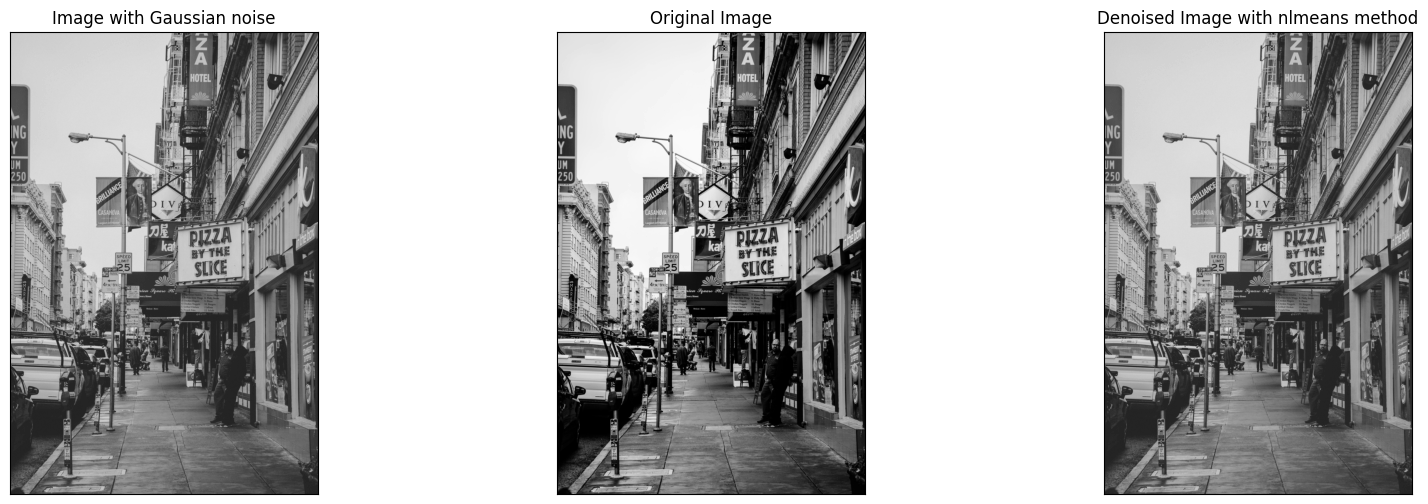

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(20, 6))  # Adjust figsize as needed

axs[0].imshow(gaussian_image_array, cmap='gray')
axs[0].set_title('Image with Gaussian noise')
axs[0].set_xticks([])
axs[0].set_yticks([])

axs[1].imshow(image_gray_array, cmap='gray')
axs[1].set_title('Original Image')
axs[1].set_xticks([])
axs[1].set_yticks([])

axs[2].imshow(gaussian_nlmeans_denoised, cmap='gray')
axs[2].set_title('Denoised Image with nlmeans method')
axs[2].set_xticks([])
axs[2].set_yticks([])

[]

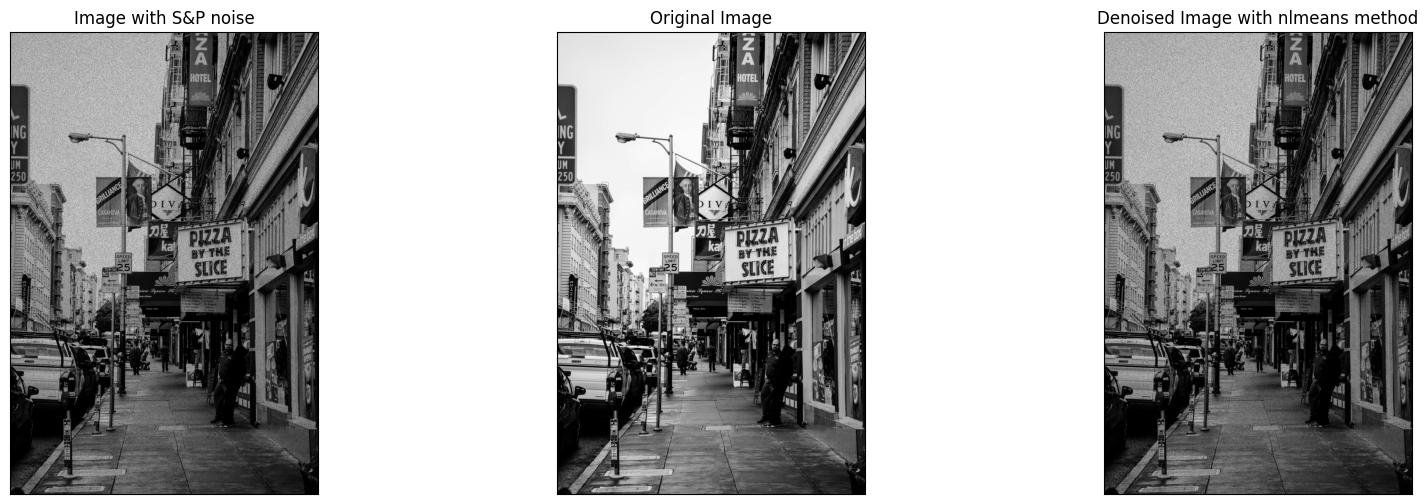

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(20, 6))  # Adjust figsize as needed

axs[0].imshow(salt_pepper_image_array, cmap='gray')
axs[0].set_title('Image with S&P noise')
axs[0].set_xticks([])
axs[0].set_yticks([])

axs[1].imshow(image_gray_array, cmap='gray')
axs[1].set_title('Original Image')
axs[1].set_xticks([])
axs[1].set_yticks([])

axs[2].imshow(salt_pepper_nlmeans_denoised, cmap='gray')
axs[2].set_title('Denoised Image with nlmeans method')
axs[2].set_xticks([])
axs[2].set_yticks([])

[]

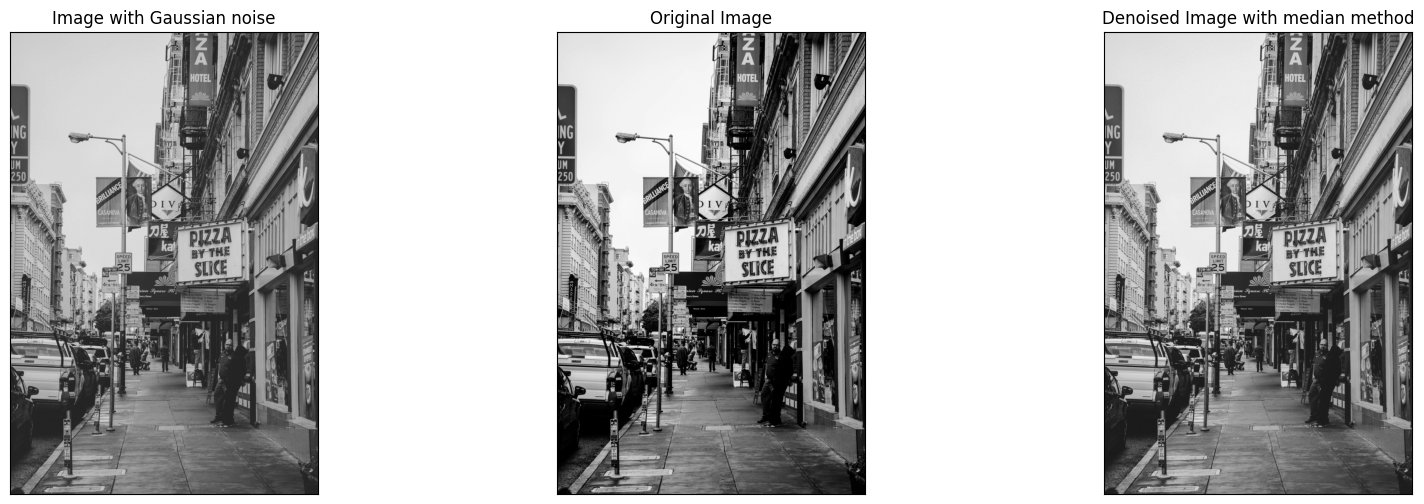

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(20, 6))  # Adjust figsize as needed
axs[0].imshow(gaussian_image_array, cmap='gray')
axs[0].set_title('Image with Gaussian noise')
axs[0].set_xticks([])
axs[0].set_yticks([])

axs[1].imshow(image_gray_array, cmap='gray')
axs[1].set_title('Original Image')
axs[1].set_xticks([])
axs[1].set_yticks([])

axs[2].imshow(gaussian_median_denoised, cmap='gray')
axs[2].set_title('Denoised Image with median method')
axs[2].set_xticks([])
axs[2].set_yticks([])

[]

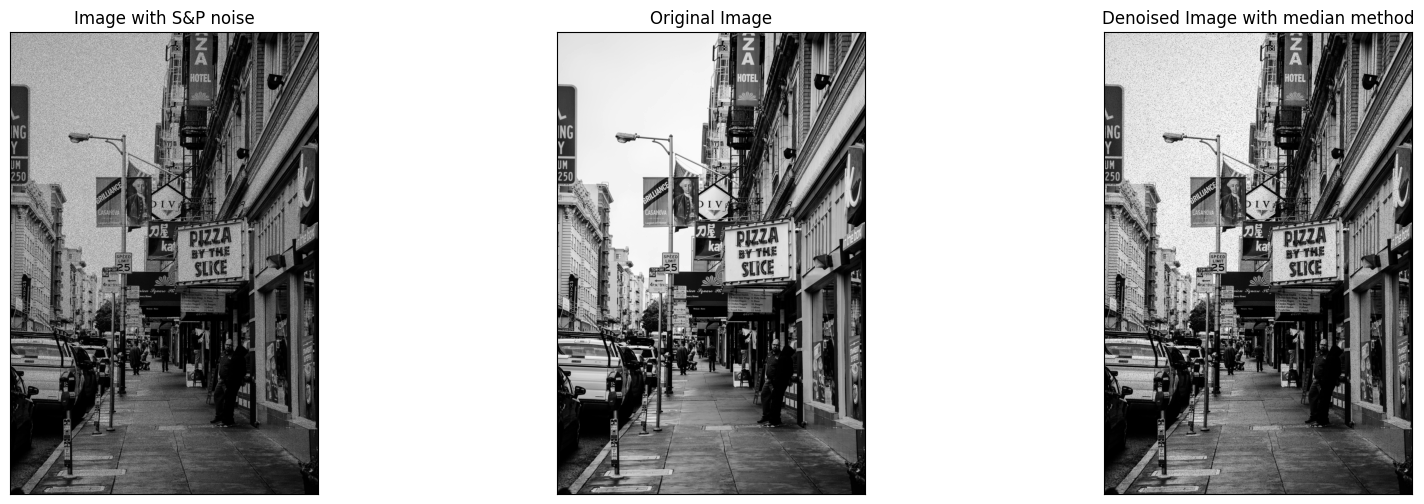

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(20, 6))  # Adjust figsize as needed

axs[0].imshow(salt_pepper_image_array, cmap='gray')
axs[0].set_title('Image with S&P noise')
axs[0].set_xticks([])
axs[0].set_yticks([])

axs[1].imshow(image_gray_array, cmap='gray')
axs[1].set_title('Original Image')
axs[1].set_xticks([])
axs[1].set_yticks([])

axs[2].imshow(salt_pepper_median_denoised, cmap='gray')
axs[2].set_title('Denoised Image with median method')
axs[2].set_xticks([])
axs[2].set_yticks([])

In [14]:
# MSE EPI SSIM
print('NLMEANS Method')
print('For Gaussian Noise')
print(f'MSE: {mse(image_gray_array.copy(), gaussian_nlmeans_denoised.copy())}')
print(f'SSIM_INDEX: {ssim_index(image_gray_array.copy(), gaussian_nlmeans_denoised.copy())}')
print(f'EPI: {epi(image_gray_array.copy(), gaussian_nlmeans_denoised.copy())}')

print()
print('For Salt & Pepper Noise')
print(f'MSE: {mse(image_gray_array.copy(), salt_pepper_nlmeans_denoised.copy())}')
print(f'SSIM_INDEX: {ssim_index(image_gray_array.copy(), salt_pepper_nlmeans_denoised.copy())}')
print(f'EPI: {epi(image_gray_array.copy(), salt_pepper_nlmeans_denoised.copy())}')

print()
print('Median Method')
print('For Gaussian Noise')
print(f'MSE: {mse(image_gray_array.copy(), gaussian_median_denoised.copy())}')
print(f'SSIM_INDEX: {ssim_index(image_gray_array.copy(), gaussian_median_denoised.copy())}')
print(f'EPI: {epi(image_gray_array.copy(), gaussian_median_denoised.copy())}')

print()
print('For Salt & Pepper Noise')
print(f'MSE: {mse(image_gray_array.copy(), salt_pepper_median_denoised.copy())}')
print(f'SSIM_INDEX: {ssim_index(image_gray_array.copy(), salt_pepper_median_denoised.copy())}')
print(f'EPI: {epi(image_gray_array.copy(), salt_pepper_median_denoised.copy())}')


NLMEANS Method
For Gaussian Noise
MSE: 99.39259675292453
SSIM_INDEX: 0.6817348237817769
EPI: -27602.296594969506

For Salt & Pepper Noise
MSE: 5489.215943150156
SSIM_INDEX: 0.27272691869149857
EPI: -79197.02692412655

Median Method
For Gaussian Noise
MSE: 34.49632231099796
SSIM_INDEX: 0.8716861102166145
EPI: -31034.78301922595

For Salt & Pepper Noise
MSE: 1274.9083214214384
SSIM_INDEX: 0.5449820347083472
EPI: -50909.510504680315


In [17]:
# NLMEANS Method data
nlmeans_data = {
    "Gaussian Noise": {"MSE": 99.39259675292453, "SSIM_INDEX": 0.6817348237817769, "EPI": -27602.296594969506},
    "Salt & Pepper Noise": {"MSE": 5489.215943150156, "SSIM_INDEX": 0.27272691869149857, "EPI": -79197.02692412655}
}

# Table for NLMEANS Method
nlmeans_table = PrettyTable()
nlmeans_table.field_names = ['Noise Type', 'MSE', 'SSIM_INDEX', 'EPI']
for noise_type, metrics in nlmeans_data.items():
    nlmeans_table.add_row([noise_type, metrics["MSE"], metrics["SSIM_INDEX"], metrics["EPI"]])

print("NLMEANS Method:")
print(nlmeans_table)

# Median Method data
median_data = {
    "Gaussian Noise": {"MSE": 34.49632231099796, "SSIM_INDEX": 0.8716861102166145, "EPI": -31034.78301922595},
    "Salt & Pepper Noise": {"MSE": 1274.9083214214384, "SSIM_INDEX": 0.5449820347083472, "EPI": -50909.510504680315}
}

# Table for Median Method
median_table = PrettyTable()
median_table.field_names = ['Noise Type', 'MSE', 'SSIM_INDEX', 'EPI']
for noise_type, metrics in median_data.items():
    median_table.add_row([noise_type, metrics["MSE"], metrics["SSIM_INDEX"], metrics["EPI"]])

print("\nMedian Method:")
print(median_table)

NLMEANS Method:
+---------------------+-------------------+---------------------+---------------------+
|      Noise Type     |        MSE        |      SSIM_INDEX     |         EPI         |
+---------------------+-------------------+---------------------+---------------------+
|    Gaussian Noise   | 99.39259675292453 |  0.6817348237817769 | -27602.296594969506 |
| Salt & Pepper Noise | 5489.215943150156 | 0.27272691869149857 |  -79197.02692412655 |
+---------------------+-------------------+---------------------+---------------------+

Median Method:
+---------------------+--------------------+--------------------+---------------------+
|      Noise Type     |        MSE         |     SSIM_INDEX     |         EPI         |
+---------------------+--------------------+--------------------+---------------------+
|    Gaussian Noise   | 34.49632231099796  | 0.8716861102166145 |  -31034.78301922595 |
| Salt & Pepper Noise | 1274.9083214214384 | 0.5449820347083472 | -50909.510504680315 |
